<img
src="http://www.telecom-em.eu/sites/default/files/logoimt2016.JPG"
WIDTH=180 HEIGHT=180>

<CENTER>
</br>
<p><font size="5">  TAF MCE - Machine Learning  </font></p>
<p><font size="5">  Kernel methods: solutions  </font></p>
</p>
</CENTER>

----------------------------

## I - Kernel density estimation

> 1. Implement the kernel density estimator with a Gaussian kernel in a function **kde(x,data=data,h=0)** where $x$ represents the locations where the density estimator is computed, $data$ the data and $h$ the bandwidth. For default value $h=0$ the bandwidth should be changed inside the function to the standard Sylverman bandwidth estimator. 
> 2. For $n=100$ samples of a $\mathcal{N}(1,1)$ distribution, plot the pdf and its estimator. 
> 3. Check the influence of the value of the bandwidth parameter.
<!--Use bandwidth parameter suggested in (https://en.wikipedia.org/wiki/Kernel_density_estimation).--> 

In [2]:
from pylab import *
%matplotlib inline

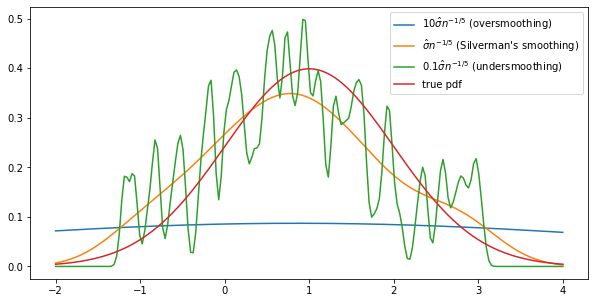

In [3]:
n       = 100
m,σ     = 1,1
data    = m+σ*randn(n)

def kde(points,data=data,h=0):
    # returns kde at points
    if h<=0: h = 1.06*std(data)*n**(-1./5)
    def K(x,h):
        return 1/sqrt(2*pi)/h*exp(-(x/h)**2/2.)
    return [mean(array([K(y-d,h) for d in data])) for y in points]

t = linspace(m-3*σ,m+3*σ,200)
h = 1.06*std(data)*n**(-1./5)
figure(figsize=(10,5))
plot(t,kde(t,h=10*h),label='$10\hat{\sigma}n^{-1/5}$ (oversmoothing)')
plot(t,kde(t,h=h),label='$\hat{\sigma}n^{-1/5}$ (Silverman\'s smoothing)')
plot(t,kde(t,h=.1*h),label='$0.1\hat{\sigma}n^{-1/5}$ (undersmoothing)')
plot(t,1/sqrt(2*pi)*exp(-((t-1))**2/2.),label='true pdf')
legend()
savefig('kernel.png')

## II - Kernel regression

Assume a pair $(X,Y)$ of random variables, with $p(x)\sim\mathcal{U}_{[-3,3]}$ and $p(y\vert x)\sim\mathcal{N}(x^2+\exp(-x),10\cos^2x)$. Implement the kernel approximation of the regression curve $\mathbb{E}[Y\vert X=x]$ and of linear regression. Test your code with sample size $n=10^3$.

In [4]:
from pylab import *
%matplotlib inline

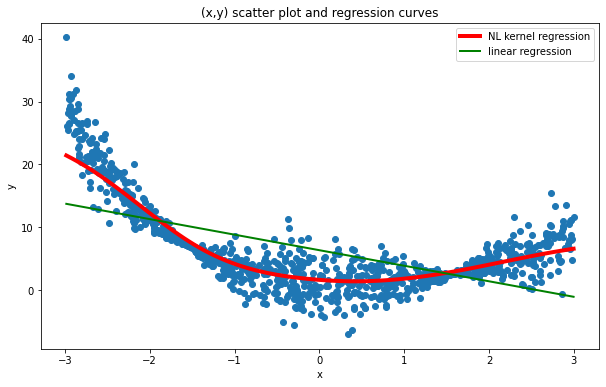

In [5]:
n  = 10**3
datax  = 6*rand(n)-3
datay  = datax**2+exp(-datax) + sqrt(10)*abs(cos(datax))*randn(n)
h = 1.06*std(datax)*n**(-1/5)

# regression of y from x: expectation of y conditioned to x
def E_y_x(vx):
    def K(x): return 1./sqrt(2*pi)/h*exp(-(x/h)**2/2.) 
    D = [mean(array([K(x-xi) for xi in datax])) for x in vx]
    N = [mean(array([yi*K(x-xi) for xi,yi in zip(datax,datay)])) for x in vx]
    return array(N)/array(D)

# linear regression
def lin_reg(x):
    mx,my       = mean(datax),mean(datay)
    cx, cy, cxy = mean((datax-mx)**2),mean((datay-my)**2), mean((datax-mx)*(datay-my))
    a = cxy/cx
    b = my-a*mx
    return a*array(x)+b

figure(figsize=(10,6))
t = linspace(min(datax),max(datax),100)
scatter(datax,datay,linewidth=1)
plot(t,E_y_x(t),'r',linewidth=4,label="NL kernel regression")
plot(t,lin_reg(t),'g',linewidth=2,label="linear regression")
legend()
xlabel('x')
ylabel('y')
title('(x,y) scatter plot and regression curves');

## III KNN

We consider 2D data generated using the code below. Each line of dataX and dataY represents points form a distinct class

    ns  = 200  # number of samples per class
    nc = 3    # number of classes
    dataX  = zeros(shape=(nc,ns))
    dataY  = zeros(shape=(nc,ns))
    dataX[0,:]  = randn(ns)
    dataY[0,:]  = sin(2*dataX[0,:]) + sqrt(.1)*randn(ns)
    dataX[1,:]  = -1 + .5*randn(ns)
    dataY[1,:]  =  1 + .5*randn(ns)
    dataX[2,:]  =  1 + .5*randn(ns)
    dataY[2,:]  = -1 + .5*randn(ns)

> 1. Visualize data and their class using a scatter plot.
> 2. Discretize the area $[-3,3]\times[-3,3]$ with 100 points per axis. For each point, compute the minimum surface $Z_{ij}=S(X_{ij},Y_{ij})$ of the disk that encloses the K nearest neighbors and represent a contour plot of $Z$
> 3. For each point of the surface, compute the posterior probabilities of the classes and plot the posterior probability map for each class. 
> 4. Plot the decision map for the class that supplies the decided class for each point based on posterior probability maximization.


Note: you could alternatively use scikit learn (https://scikit-learn.org/stable/modules/neighbors.html)

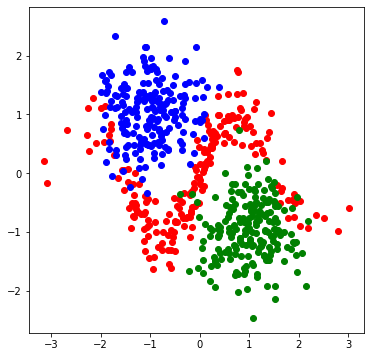

In [8]:
ns  = 200  # number of samples per class
nc = 3    # number of classes
dataX  = zeros(shape=(nc,ns))
dataY  = zeros(shape=(nc,ns))
dataX[0,:]  = randn(ns)
dataY[0,:]  = sin(2*dataX[0,:]) + sqrt(.1)*randn(ns)
dataX[1,:]  = -1 + .5*randn(ns)
dataY[1,:]  =  1 + .5*randn(ns)
dataX[2,:]  =  1 + .5*randn(ns)
dataY[2,:]  = -1 + .5*randn(ns)

figure(figsize=(6,6))
scatter(dataX[0,:],dataY[0,:],color="r")
scatter(dataX[1,:],dataY[1,:],color="b")
scatter(dataX[2,:],dataY[2,:],color="g");

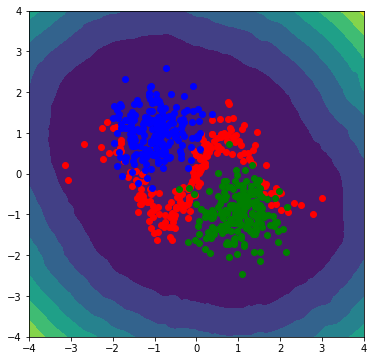

In [10]:
K   = 10    # number of neighboors
np  = 100   # discretization
d   = 4
x   = linspace(-4,4,np)
y   = linspace(-4,4,np)
X,Y = meshgrid(x,y)

# def KNN(data)
dataX_ = reshape(dataX,(1,nc*ns))[0]
dataY_ = reshape(dataY,(1,nc*ns))[0]
Z      = zeros(shape=(np,np))

K = 10
for i in range(np):
    for j in range(np):
        ind    = argsort((X[i,j]-dataX_)**2+(Y[i,j]-dataY_)**2)[K-1]
        Z[i,j] = pi*((X[i,j]-dataX_[ind])**2+(Y[i,j]-dataY_[ind])**2)

figure(figsize=(6,6))
contourf(X,Y,Z)
scatter(dataX[0,:],dataY[0,:],color="r")
scatter(dataX[1,:],dataY[1,:],color="b")
scatter(dataX[2,:],dataY[2,:],color="g");

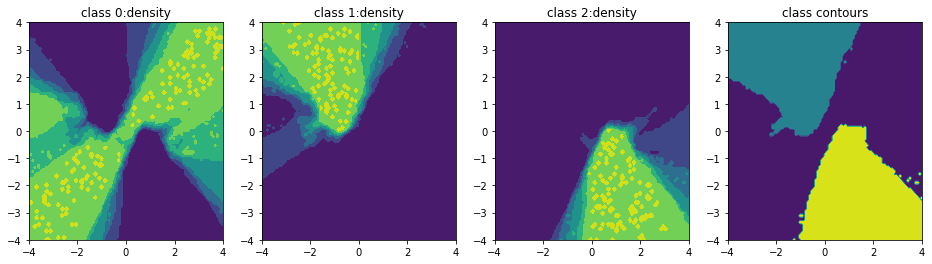

In [23]:
figure(figsize=(16,4))

Zc = zeros(shape=(np,np,nc))
for i in range(np):
    for j in range(np):
        d2 = (X[i,j]-dataX_)**2+(Y[i,j]-dataY_)**2
        r2 = Z[i,j]/pi
        for c in range(nc):
            dc = [d2[k] for k in range(c*ns,(c+1)*ns) if d2[k]<r2]
            Zc[i,j,c] = len(dc)/K
            
for k in range(nc):
    s = subplot(1,nc+1,k+1)
    contourf(X,Y,Zc[:,:,k])
    s.title.set_text("class %d:density" %k)


state_post = zeros(shape=(np,np))
for i in range(np):
    for j in range(np):
        state_post[i,j] = argsort(array([Zc[i,j,c] for c in range(nc)]))[-1]+1

s = subplot(1,nc+1,nc+1)        
contourf(X,Y,state_post)
s.title.set_text("class contours")

## IV - Kernel methods with scikit-learn

We illustrate the use of scikit-learn for kernel density estimation by considering a simple example.

> 1. generate a set of data that contains $2.10^4$ samples with $\mathcal{N}(0,100)$ distribution, $10^4$ samples with $\mathcal{N}(3,1)$ distribution and $10^4$ samples with $\mathcal{N}(2,4)$ distribution.
> 2. Plot the kernel density estimator obtained using the **KernelDensity** function of scikit-learn.


Note: you could also use scikit learn for KNN (https://scikit-learn.org/stable/modules/neighbors.html)

In [1]:
from pylab import *
%matplotlib inline

from sklearn.neighbors import KernelDensity
import scipy.stats as sst

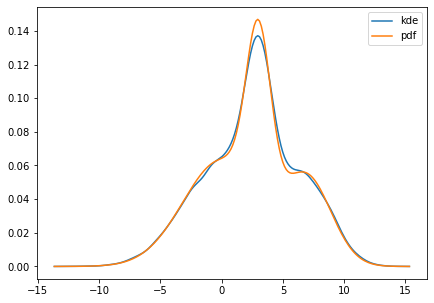

In [2]:
n       = array([2,1,1])*10**4
a       = 0,3,7
b       = sqrt(10),1,2
data    = concatenate([a[0]+b[0]*randn(n[0]),
                       a[1]+b[1]*randn(n[1]),
                       a[2]+b[2]*randn(n[2])])
data    = reshape(data,(sum(n),1)) # KernelDensity requires a column vector
# optimal bandwidth (https://en.wikipedia.org/wiki/Kernel_density_estimation)
h       = 1.06*std(data)/len(data)**(1/5)
KDE     = KernelDensity(kernel='gaussian', bandwidth=h).fit(data)

x       = linspace(data.min()-1,data.max()+1,200)[:,np.newaxis]
log_KDE = KDE.score_samples(x) # kde is supplied in log scale

figure(figsize=(7,5))
plot(x,exp(log_KDE),label="kde") 
# True pdf
def pdf(x):
    p = array(n)/sum(n)
    return array([p[0]*sst.norm.pdf(u,loc=a[0],scale=b[0]) #*(a[0]+(0<=u<=b[0])/b[0])
                 +p[1]*sst.norm.pdf(u,loc=a[1],scale=b[1])
                 +p[2]*sst.norm.pdf(u,loc=a[2],scale=b[2]) for u in x]) 
plot(x,pdf(x),label="pdf")
legend()